In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_skimage

In [2]:

def combined_loss_m(y_true, y_pred):
    """
    Custom loss function that combines:
    - Mean Squared Error (MSE)
    - Structural Similarity Index (SSIM)
    - Mean Absolute Error (MAE)

    The weights are adjusted to prioritize perceptual similarity (SSIM),
    while still penalizing absolute and squared differences.

    Returns:
        Weighted sum: 0.2 * MSE + 0.7 * SSIM + 0.1 * MAE
    """
    mse = K.mean(K.square(y_true - y_pred))
    mae = K.mean(K.abs(y_true - y_pred))
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

    return 0.2 * mse + 0.7 * ssim + 0.1 * mae

def combined_loss(y_true, y_pred):
    """
    Combined custom loss function for phase regression.

    This loss blends:
    - Circular MSE (main component) to handle periodicity
    - SSIM (Structural Similarity Index) to preserve spatial structures
    - Circular MAE as an auxiliary error term

    Final loss = 0.8 * circular_MSE + 0.1 * SSIM + 0.1 * circular_MAE

    Returns:
        Tensor: Weighted sum of losses.
    """
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    diff = y_true - y_pred
    diff = tf.atan2(tf.sin(diff), tf.cos(diff))  # Normalize difference to [-π, π]

    circ_mse = tf.reduce_mean(tf.square(diff))
    circ_mae = tf.reduce_mean(tf.abs(diff))

    #return 0.8 * circ_mse + 0.1 * ssim + 0.1 * circ_mae
    return 0.9 * circ_mse + 0.1 * circ_mae

def phase_clip(x):
    """Función para asegurar que la salida esté en [-π, π]"""
    return tf.clip_by_value(x, -np.pi, np.pi)

# Load model with custom object
magnitude_model = tf.keras.models.load_model(
    "magnitude_skinsubstraction.keras",
    custom_objects={"combined_loss_m": combined_loss_m}
)

phase_model = tf.keras.models.load_model(
    "phase_skinsubstraction.keras",
    custom_objects={"combined_loss": combined_loss, "phase_clip": phase_clip}
)

In [3]:
def denormalize(normalized_magnitude, percentiles_mag, indices):
    """
    Denormalize a batch of normalized magnitude data using the original percentiles.

    Parameters:
    -----------
    normalized_magnitude : np.ndarray
        Normalized data in [0, 1], shape: (N, F, A).
    percentiles_mag : list of tuples
        List containing (lower, upper) percentile values for each original sample.
    indices : list or np.ndarray
        Indices pointing to which original sample each row of `normalized_magnitude` comes from.
        This is typically used after splitting the dataset (e.g. for test/validation).

    Returns:
    --------
    mag_denorm : np.ndarray
        Denormalized magnitude data with original scale restored.
    """
    mag_denorm = np.zeros_like(normalized_magnitude)

    for i in range(normalized_magnitude.shape[0]):
        original_idx = indices[i]
        mag_p_lower, mag_p_upper = percentiles_mag[original_idx]

        # Revert normalization
        mag_denorm[i] = normalized_magnitude[i] * (mag_p_upper - mag_p_lower) + mag_p_lower

    return mag_denorm

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step
Visualizing sample 0 (original index: 311)


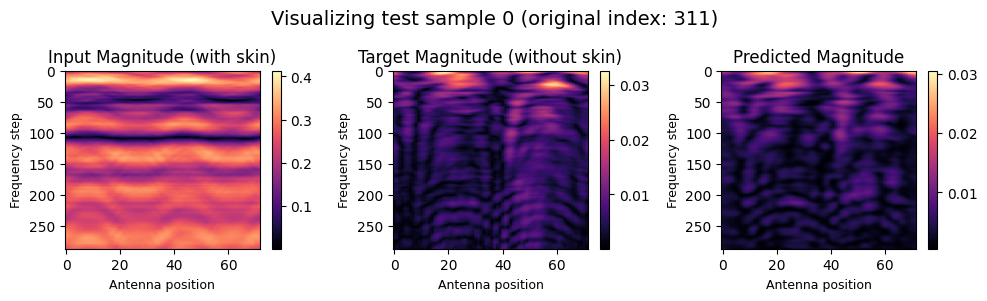

Magnitude:
MSE: 0.0000081269
MAE: 0.0019688328
SSIM: 0.3732458983
Correlation: 0.8677840814


In [11]:
X_testm = np.load("X_testm.npy")
y_testm = np.load("y_testm.npy")
percentiles_ws_mag_ = np.load("percentiles_ws_mag_.npy")
indices_testm = np.load("indices_testm.npy")
with open("normalization_info.pkl", "rb") as f:
    normalization_info_ = pickle.load(f)

# Predict the output on the test set using the trained model
y_pred_ = magnitude_model.predict(X_testm)

# Denormalize the input magnitude data (X_test) to the original scale
input_mag_denorm_ = denormalize(
    X_testm,  # Magnitude of the input
    normalization_info_['percentiles_ws_mag'],  # Normalization info
    indices_testm  # Indices for test set
)

target_magnitude = y_testm / 100
predicted_magnitude = (y_pred_ / 100)

# Select an index to visualize the prediction
idx = 0
print(f"Visualizing sample {idx} (original index: {indices_testm[idx]})")

# Create the plots to visualize the magnitude input, target, and predicted data
plt.figure(figsize=(10, 5))
plt.suptitle(f"Visualizing test sample {idx} (original index: {indices_testm[idx]})", fontsize=14)

# Visualize input magnitude (with surface)
plt.subplot(2, 3, 1)
plt.title("Input Magnitude (with skin)")
plt.xlabel('Antenna position', fontsize=9)
plt.ylabel('Frequency step', fontsize=9)
im1 = plt.imshow(input_mag_denorm_[idx], cmap='magma', aspect='auto')
plt.colorbar(im1)

# Visualize the target magnitude (without surface)
plt.subplot(2, 3, 2)
plt.title("Target Magnitude (without skin)")
plt.xlabel('Antenna position', fontsize=9)
plt.ylabel('Frequency step', fontsize=9)
im2 = plt.imshow(target_magnitude[idx], cmap='magma', aspect='auto')
plt.colorbar(im2)

# Visualize predicted magnitude from the U-Net model
plt.subplot(2, 3, 3)
plt.title("Predicted Magnitude")
plt.xlabel('Antenna position', fontsize=9)
plt.ylabel('Frequency step', fontsize=9)
im3 = plt.imshow(predicted_magnitude[idx], cmap='magma', aspect='auto')
plt.colorbar(im3)

plt.tight_layout()  # Adjust layout for better presentation
plt.show()  # Display the plot



def calculate_metrics(true_data, pred_data):
    """Calculates error metrics between true and predicted data"""
    
    # Ensure the data is in numpy array format
    if isinstance(true_data, tf.Tensor):
        true_data = true_data.numpy()
    if isinstance(pred_data, tf.Tensor):
        pred_data = pred_data.numpy()
    
    # Basic metrics: MSE and MAE
    mse = np.mean((true_data - pred_data) ** 2)
    mae = np.mean(np.abs(true_data - pred_data))
    
    # SSIM calculation using scikit-image (recommended for image data)
    try:
        if len(true_data.shape) == 4:  # For batch data (batch, height, width, channels)
            ssim_values = []
            for i in range(true_data.shape[0]):
                img1 = true_data[i, :, :, 0] if true_data.shape[-1] == 1 else true_data[i]
                img2 = pred_data[i, :, :, 0] if pred_data.shape[-1] == 1 else pred_data[i]
                ssim_val = ssim_skimage(img1, img2, data_range=img1.max() - img1.min())
                ssim_values.append(ssim_val)
            ssim = np.mean(ssim_values)
            
        elif len(true_data.shape) == 3:  # For single image data (height, width, channels)
            img1 = true_data[:, :, 0] if true_data.shape[-1] == 1 else true_data
            img2 = pred_data[:, :, 0] if pred_data.shape[-1] == 1 else pred_data
            ssim = ssim_skimage(img1, img2, data_range=img1.max() - img1.min())
            
        else:  # 2D case (single image)
            ssim = ssim_skimage(true_data, pred_data, data_range=true_data.max() - true_data.min())
            
    except Exception as e:
        print(f"Error calculating SSIM with scikit-image: {e}")
        ssim = np.nan  # Return NaN if SSIM calculation fails
    
    # Correlation metric
    try:
        correlation = np.corrcoef(true_data.flatten(), pred_data.flatten())[0, 1]
    except:
        correlation = np.nan  # Return NaN if correlation calculation fails
    
    return {
        'MSE': mse,  # Mean Squared Error
        'MAE': mae,  # Mean Absolute Error
        'SSIM': 1-ssim,  # Structural Similarity Index
        'Correlation': correlation  # Pearson Correlation Coefficient
    }



# Evaluate the model's metrics on the test set
print("Magnitude:")

# Calculate metrics for the predicted magnitude vs. actual magnitude
mag_metrics_ = calculate_metrics(y_testm/100, y_pred_/100)

# Print out the calculated metrics
for metric, value in mag_metrics_.items():
    print(f"{metric}: {value:.10f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 863ms/step
Visualizing test sample 30 (original index: 9)


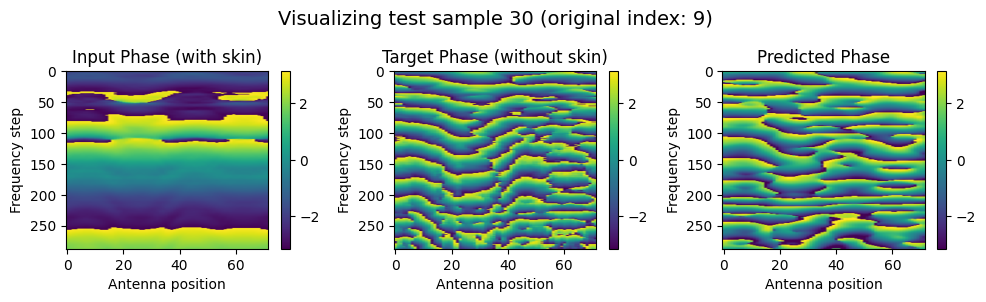

Phase:
Circular MSE: 1.468353
Circular MAE: 0.931537
Correlation: 0.495466


In [7]:
# === Phase Prediction, Visualization, and Circular Metrics Evaluation ===
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
indices_test = np.load("indices_test.npy")
# Predict on the test set
predicted_phase = phase_model.predict(X_test)

# Select a specific test sample to visualize
idx = 30
print(f"Visualizing test sample {idx} (original index: {indices_test[idx]})")

# --- Create visualization for input, target, and prediction ---
plt.figure(figsize=(10, 5))
plt.suptitle(f"Visualizing test sample {idx} (original index: {indices_test[idx]})", fontsize=14)


# Input phase with skin
plt.subplot(2, 3, 1)
plt.title("Input Phase (with skin)")
plt.xlabel('Antenna position')
plt.ylabel('Frequency step')
im1 = plt.imshow(X_test[idx], cmap='viridis', aspect='auto')
plt.colorbar(im1)

# Ground-truth (target) phase without skin
plt.subplot(2, 3, 2)
plt.title("Target Phase (without skin)")
plt.xlabel('Antenna position')
plt.ylabel('Frequency step')
im2 = plt.imshow(y_test[idx], cmap='viridis', aspect='auto')
plt.colorbar(im2)

# Predicted phase from U-Net model
plt.subplot(2, 3, 3)
plt.title("Predicted Phase")
plt.xlabel('Antenna position')
plt.ylabel('Frequency step')
im3 = plt.imshow(predicted_phase[idx], cmap='viridis', aspect='auto')
plt.colorbar(im3)

plt.tight_layout()
plt.show()



def circular_correlation(true_phase, pred_phase):
    """
    Calculates the circular correlation between true and predicted phase values.

    This method is based on the projection of both true and predicted phase values onto 
    their sine and cosine components. It computes a correlation value between the two 
    phase signals in a way that accounts for the circular nature of phase data (i.e., 
    the periodicity of angles).

    Parameters:
    - true_phase (numpy.ndarray): The true phase values (in radians).
    - pred_phase (numpy.ndarray): The predicted phase values (in radians).

    Returns:
    - float: The correlation coefficient between the true and predicted phases, based on 
      their sine and cosine projections.
    """
    # Compute the sine and cosine of the true and predicted phases
    sin_true = np.sin(true_phase)
    cos_true = np.cos(true_phase)
    sin_pred = np.sin(pred_phase)
    cos_pred = np.cos(pred_phase)

    # Compute the numerator of the circular correlation
    num = np.mean(sin_true * sin_pred + cos_true * cos_pred)

    # Compute the denominator of the circular correlation
    den = np.sqrt(np.mean(sin_true**2 + cos_true**2) * np.mean(sin_pred**2 + cos_pred**2))

    # Return the final circular correlation
    return num / den



def calculate_circular_metrics(true_phase, pred_phase):
    """
    Calculates circular error metrics between true and predicted phase values.

    This function computes three key metrics to evaluate the accuracy of phase predictions:
    - Circular Mean Squared Error (MSE): Measures the squared angular difference between 
      true and predicted phases, adjusted to the circular domain.
    - Circular Mean Absolute Error (MAE): Measures the absolute angular difference between 
      true and predicted phases, adjusted to the circular domain.
    - Circular Correlation: Measures the correlation between the true and predicted phase 
      values, accounting for phase periodicity.

    Parameters:
    - true_phase (numpy.ndarray): The true phase values (in radians).
    - pred_phase (numpy.ndarray): The predicted phase values (in radians).

    Returns:
    - dict: A dictionary containing the following metrics:
        - 'Circular MSE': Mean squared error between true and predicted phases.
        - 'Circular MAE': Mean absolute error between true and predicted phases.
        - 'Correlation': Circular correlation between true and predicted phases.
    """
    # Calculate the angular difference between true and predicted phases in the circular domain [-π, π]
    diff = np.angle(np.exp(1j * (true_phase - pred_phase)))
    
    # Calculate Circular Mean Squared Error (MSE)
    mse = np.mean(diff ** 2)

    # Calculate Circular Mean Absolute Error (MAE)
    mae = np.mean(np.abs(diff))
    
    # Calculate the correlation coefficient between the true and predicted phases
    correlation = np.corrcoef(true_phase.flatten(), pred_phase.flatten())[0, 1]
    
    # Calculate the circular correlation using the defined method
    correlation1 = circular_correlation(true_phase, pred_phase)

    # Return the calculated metrics as a dictionary
    return {
        'Circular MSE': mse,
        'Circular MAE': mae,
        'Correlation': correlation1
    }

# Example of evaluating phase metrics
print("Phase:")
# Calculate and print circular metrics for the true and predicted phase values
phase_metrics_ = calculate_circular_metrics(y_test, predicted_phase)
for metric, value in phase_metrics_.items():
    print(f"{metric}: {value:.6f}")

In [10]:
#idx = [4, 8, 9, 11, 12, 24, 30, 36, 40, 43]
s11 = predicted_magnitude * np.exp(1j * predicted_phase)

with open("predicted_test_v2.pickle", "wb") as f:
    pickle.dump(s11, f)